<a href="https://colab.research.google.com/github/Mcentenera/HR-Estimator/blob/main/MARCOT-HR%20Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MARCOT-HR Estimator Code

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Formules used

Modes supported by a fibre:

\begin{equation}
V=\frac{2\pi r_{core}}{\lambda}NA
\end{equation}

\begin{equation}
M=\frac{V^2}{2}
\end{equation}

Where $r_{core}$ is the radius of the fibre core, $NA$

Efficiency is calculated taking into acount just the modes coservation:

\begin{equation}
loss=10\cdot log_{10}\left(\frac{M_{in}}{M_{out}}\right)
\end{equation}

In [66]:
def marcot_hr_estimator(
    module_diameter_m = 5,
    ota_diameter_m = 0.406,
    f_number_ota = 8,
    seeing_fwhm_arcsec = 0.85,
    use_tip_tilt = False,
    target_encircled_energy = 0.95,
    NA_in = 0.1,
    NA_out = 0.22,
    wavelength_min_nm = 500,
    wavelength_max_nm = 1000,
    desired_resolution = 100000,
    magnification_factor = 1.2,
    pseudoslit = True,
    super_pl = False
):

    #####################################################################################################
    # 1. TELESCOPE MODULE
    #####################################################################################################

    module_area = math.pi * (module_diameter_m / 2)**2
    ota_area = math.pi * (ota_diameter_m / 2)**2
    n_otas = math.ceil(module_area / ota_area)

    ota_diameter_mm = ota_diameter_m * 1000
    focal_length_mm = f_number_ota * ota_diameter_mm
    plate_scale_arcsec_per_mm = 206265 / focal_length_mm

    effective_seeing_arcsec = seeing_fwhm_arcsec * (0.7 if use_tip_tilt else 1.0)
    psf_fwhm_mm = effective_seeing_arcsec / plate_scale_arcsec_per_mm
    fiber_core_mm = 1.5 * psf_fwhm_mm  # 1.5xFWHM to capture 90–95% energy
    fiber_core_microns = fiber_core_mm * 1000

    #####################################################################################################
    # 2. PHOTONIC LANTERN
    #####################################################################################################

    fiber_core_m = fiber_core_microns * 1e-6
    wavelengths_m = [wavelength_min_nm * 1e-9, wavelength_max_nm * 1e-9]

    #modes_per_fiber = []

    def modes(l, d, NA):
      return (1/2)*((((2*np.pi*d)/(2*l))*NA)**2)

    #for wl in wavelengths_m:
    #    V = (2 * math.pi * (fiber_core_m / 2) / wl) * NA_in
    #    M = (V**2) / 2
    #    modes_per_fiber.append(M)

    #modes_total_per_module = [n_otas * m for m in modes_per_fiber]

    modes_total_per_module = [n_otas * modes(wavelength_min_nm * 1e-9, fiber_core_m, NA_in)]

    wl_short = wavelengths_m[0]
    V_required = math.sqrt(2 * modes_total_per_module[0])
    a_required_m = (V_required * wl_short) / (2 * math.pi * NA_out)
    core_required_microns = 2 * a_required_m * 1e6

    # Choose commercial option
    if core_required_microns <= 100:
        fiber_core_output_microns = 100
    elif core_required_microns <= 200:
        fiber_core_output_microns = 200
    elif core_required_microns <= 300:
        fiber_core_output_microns = 300
    else:
        fiber_core_output_microns = 400

    loss_comm = 10 * np.log10( n_otas * modes(wavelength_min_nm * 1e-9, fiber_core_m, NA_in) / modes(wavelength_min_nm * 1e-9, fiber_core_output_microns * 1e-6, NA_out))

    efficiency_comm = 1 - 10 ** (loss_comm / 10)

    # Force output of 100 microns (como CARMENES)
    forced_output_core_microns = 100
    a_forced_output_m = (forced_output_core_microns / 2) * 1e-6
    V_forced_output = (2 * math.pi * a_forced_output_m / wl_short) * NA_out
    modes_per_forced_output_fiber = (V_forced_output**2) / 2

    fibers_per_module_output = math.ceil(modes_total_per_module[0] / modes_per_forced_output_fiber)
    modes_per_each_100_micron_fiber = modes_total_per_module[0] / fibers_per_module_output

    total_modules = math.ceil((math.pi * (15 / 2)**2) / module_area)

    if pseudoslit:
        total_fibers_pseudoslit = total_modules * fibers_per_module_output
    elif super_pl:
        total_modes_all_modules = total_modules * modes_total_per_module[0]
        num_super_output_fibers = math.ceil(total_modes_all_modules / modes_per_forced_output_fiber)
        total_fibers_pseudoslit = num_super_output_fibers
    else:
        total_fibers_pseudoslit = total_modules * fibers_per_module_output

    #####################################################################################################
    # 3. SPECTROGRAPH / INSTRUMENT
    #####################################################################################################

    fiber_core_mm_entry = fiber_core_microns / 1000
    beam_diameter_mm = fiber_core_mm_entry * magnification_factor * desired_resolution

    base_volume_m3 = 14  # ESPRESSO baseline
    base_beam_mm = 200
    volume_scale = (beam_diameter_mm / base_beam_mm)**3

    spectrograph_volume_m3 = base_volume_m3 * volume_scale
    spectrograph_weight_kg = 4000 * volume_scale
    cost_estimate_meur = 6 * volume_scale

    #####################################################################################################
    # RESULTS
    #####################################################################################################

    results = {
        # Telescope
        "Module diameter (m)": module_diameter_m,
        "OTA diameter (m)": ota_diameter_m,
        "Number of OTAs": n_otas,
        "F-number OTA": f_number_ota,
        "Focal length (mm)": focal_length_mm,
        "Seeing FWHM (arcsec)": seeing_fwhm_arcsec,
        "Effective seeing (arcsec)": effective_seeing_arcsec if use_tip_tilt else seeing_fwhm_arcsec,
        "Input fiber core (microns)": np.round(fiber_core_microns,3),

        # Photonic Lantern
        "": None,
        #"Modes per fiber [500nm,1000nm]": np.round(modes_per_fiber, 0),
        "Modes per fiber [500nm,1000nm]": np.array([np.round(modes(wavelength_min_nm * 1e-9, fiber_core_m, NA_in), 0),np.round(modes(wavelength_max_nm * 1e-9, fiber_core_m, NA_in), 0)]),
        "Total modes per module": np.array([np.round(n_otas * modes(wavelength_min_nm * 1e-9, fiber_core_m, NA_in), 0), np.round(n_otas * modes(wavelength_min_nm * 1e-9, fiber_core_m, NA_in), 0)]),
        "Required output fiber core (microns)": np.round(core_required_microns,3),
        "Selected commercial output core (microns)": np.round(fiber_core_output_microns,3),
        "Expected efficiency (%)": np.round(efficiency_comm * 100,3),
        "Fibers per module @100µm": np.round(fibers_per_module_output,3),
        "Modes per 100µm fiber": math.ceil(modes_per_each_100_micron_fiber),
        "Total modules": total_modules,
        "Total fibers at pseudorendija": total_fibers_pseudoslit,

        # Spectrograph
        "": None,
        "Beam diameter at spectrograph (mm)": np.round(beam_diameter_mm,3),
        "Spectrograph volume (m³)": np.round(spectrograph_volume_m3,3),
        "Spectrograph weight (kg)": np.round(spectrograph_weight_kg,3),
        "Estimated cost (MEUR)": np.round(cost_estimate_meur,3),

        # Auxiliar parameters
        "Use tip/tilt?": use_tip_tilt,
        "Magnification factor": magnification_factor,
        "Pseudoslit": pseudoslit,
        "Super-PL": super_pl
    }

    return results


In [67]:
def print_results(results):
    def print_section(title):
        print(f"\n{'=' * 60}\n{title:^60}\n{'=' * 60}")

    print_section("TELESCOPE")
    keys_tel = [k for k in results if any(s in k for s in ["OTA", "Seeing", "fiber core", "Module", "F-number", "Focal length"])]
    for k in keys_tel:
        print(f"{k:<45}: {results[k]}")

    print_section("PHOTONIC LANTERN")
    keys_pl = [k for k in results if any(s in k for s in ["Expected", "Modes", "Fibers", "Required output", "Selected", "Super-PL"])]
    for k in keys_pl:
        print(f"{k:<45}: {results[k]}")

    print_section("SPECTROGRAPH")
    keys_instr = [k for k in results if any(s in k for s in ["Beam diameter", "Spectrograph", "Estimated cost", "Magnification"])]
    for k in keys_instr:
        print(f"{k:<45}: {results[k]}")

    print_section("AUXILIAR PARAMETERS")
    other_keys = [k for k in results if k not in keys_tel + keys_pl + keys_instr and k != ""]
    for k in other_keys:
        print(f"{k:<45}: {results[k]}")

# Ejecución principal
if __name__ == "__main__":
    parameters = marcot_hr_estimator(
        module_diameter_m = 5,
        ota_diameter_m = 0.406,
        f_number_ota = 8,
        seeing_fwhm_arcsec = 0.85,
        use_tip_tilt = False,
        target_encircled_energy = 0.95,
        NA_in = 0.1,
        NA_out = 0.22,
        wavelength_min_nm = 500,
        wavelength_max_nm = 1000,
        desired_resolution = 100000,
        magnification_factor = 1.2,
        pseudoslit = True,
        super_pl = False
    )

    print_results(parameters)



                         TELESCOPE                          
Module diameter (m)                          : 5
OTA diameter (m)                             : 0.406
Number of OTAs                               : 152
F-number OTA                                 : 8
Focal length (mm)                            : 3248.0
Seeing FWHM (arcsec)                         : 0.85
Input fiber core (microns)                   : 20.077
Required output fiber core (microns)         : 112.512

                      PHOTONIC LANTERN                      
Modes per fiber [500nm,1000nm]               : [80. 20.]
Required output fiber core (microns)         : 112.512
Selected commercial output core (microns)    : 200
Expected efficiency (%)                      : 68.352
Fibers per module @100µm                     : 2
Modes per 100µm fiber                        : 6048
Super-PL                                     : False

                        SPECTROGRAPH                        
Beam diameter at spectrogr

## Comments

Hay que revisar cómo calcula el tamaño de fibra de entrada adecuado

Hay que revisar que los modos de la salida los esté calculando con el NA=0.22

A lo mejor no hay que fijar tanto el diámetro del módulo, sino el número de OTAS que queremos usar. Pensando en la PL los números que permiten un buen empaquetado, y por tanto, una alta eficiencia, son:

Recordemos que este estudio se hace teniendo en cuenta la fórmula:

\begin{equation}
D=n\left(\frac{d_2}{d_1}\right)^2
\end{equation}

Where $d_1$ is the inner diameter of the capillary, $d_2$ is the cladding diameter of the fibers and $n$ is the number of fibers. El empaquetamiento hexagonal es el más eficiente y la densidad de empacado teórica máxima que se puede conseguir es de $D=0.9069$, si la densidad de empaquetado sale mayor de ese valor, no es físicamente posible hacerlo.

Por lo tanto, para saber el diámetro interno del capilar en valor absoluto, podemos usar la fórmula:

\begin{equation}
d_1 = \frac{\sqrt{n}}{0.9069}
\end{equation}

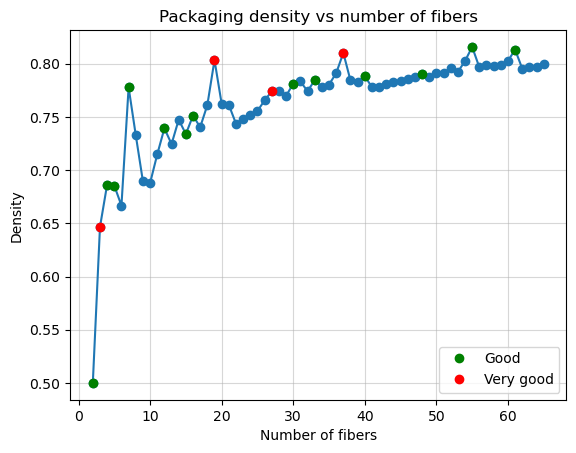

In [ ]:
def pack_den(n, d_1, d_2):
    return n * (d_2/d_1) **2

n, d_1= np.loadtxt("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas.txt",usecols=(0, 1),unpack=True)
Q = np.loadtxt("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas.txt", dtype=str, usecols=(2),unpack=True)

df = pd.read_csv("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas.txt")

# Add new column
density = pack_den(n, d_1, 1)
df["Pack_density"] = density

# Save as new file
df.to_csv("/Users/mcentenera/Nextcloud/HR_estimator/Pruebas_den.txt", sep="\t", index=False)

bad = []
good = []
n_good = []
okay = []
very_good = []
n_very_good = []

plt.plot(n, pack_den(n, d_1, 1), 'o-')
for i in range(0,len(Q)):
    if Q[i]=="'Bad'":
        bad.append(density[i])

    elif Q[i]=="'Good'":
        good.append(density[i])
        n_good.append(n[i])

    elif Q[i]=="'Okay'":
        okay.append(density[i])

    elif Q[i]=="'Very_good'":
        very_good.append(density[i])
        n_very_good.append(n[i])

for i in range(0,len(good)):
    if i==0:
        plt.plot(n_good[i], good[i], 'go', label = 'Good')
    else:
        plt.plot(n_good[i], good[i], 'go')

for i in range(0,len(very_good)):
    if i==0:
        plt.plot(n_very_good[i], very_good[i], 'ro', label = 'Very good')
    else:
        plt.plot(n_very_good[i], very_good[i], 'ro')

plt.title('Packaging density vs number of fibers')
plt.xlabel('Number of fibers')
plt.ylabel('Density')
plt.grid(which='minor', alpha=0)
plt.grid(which='major', alpha=0.5)
lgnd = plt.legend(loc="lower right")
plt.show()

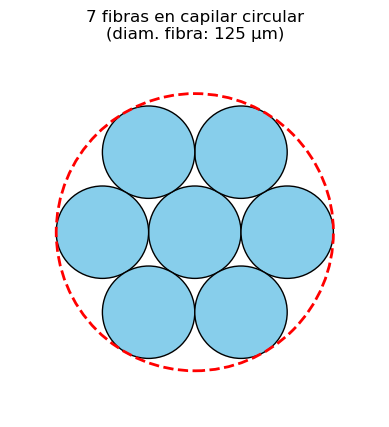

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

def generate_hex_packing(n_layers, fiber_radius):
    """Genera coordenadas (x, y) para el empaquetamiento hexagonal compacto"""
    coords = [(0, 0)]  # centro
    for layer in range(1, n_layers + 1):
        for i in range(6):
            angle = math.pi / 3 * i
            for j in range(layer):
                x = (layer * fiber_radius * 2) * math.cos(angle) - (j * fiber_radius * 2) * math.sin(angle)
                y = (layer * fiber_radius * 2) * math.sin(angle) + (j * fiber_radius * 2) * math.cos(angle)
                coords.append((x, y))
    return coords

def plot_fiber_packing(fiber_diameter, num_fibers):
    fiber_radius = fiber_diameter / 2

    # Aproximamos cuántas capas de anillos concéntricos necesitamos
    n_layers = 0
    while True:
        estimated_fibers = 1 + 3 * n_layers * (n_layers + 1)
        if estimated_fibers >= num_fibers:
            break
        n_layers += 1

    coords = generate_hex_packing(n_layers, fiber_radius)
    coords = coords[:num_fibers]  # cortamos al número de fibras deseado

    # Estimamos el radio del capilar que los contiene
    max_r = max(np.hypot(x, y) for x, y in coords) + fiber_radius

    fig, ax = plt.subplots()
    ax.set_aspect('equal')


    # Dibujamos cada fibra
    for (x, y) in coords:
        circle = plt.Circle((x, y), fiber_radius, color='skyblue', ec='black')
        ax.add_artist(circle)

    # Dibujamos el capilar
    capillary = plt.Circle((0, 0), max_r, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_artist(capillary)

    ax.set_xlim(-max_r - fiber_radius, max_r + fiber_radius)
    ax.set_ylim(-max_r - fiber_radius, max_r + fiber_radius)
    ax.set_title(f'{num_fibers} fibras en capilar circular\n(diam. fibra: {fiber_diameter} μm)')
    plt.axis('off')
    plt.show()

# Ejemplo de uso
plot_fiber_packing(fiber_diameter=125, num_fibers=7)


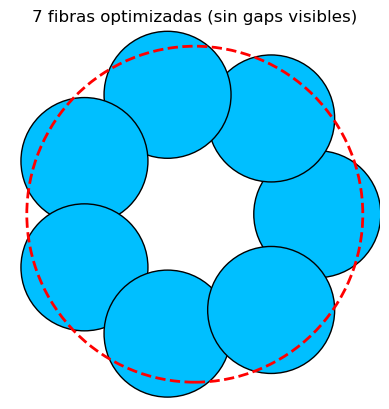

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def create_initial_positions(n, radius):
    # Posiciones iniciales aleatorias en el círculo
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    r = radius * 0.5
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    return np.stack((x, y), axis=1).flatten()

def pack_cost(positions, n, r_fiber):
    positions = positions.reshape((n, 2))
    total_penalty = 0
    for i in range(n):
        xi, yi = positions[i]
        # Penalizar si está fuera del círculo
        if np.hypot(xi, yi) + r_fiber > 1:
            total_penalty += 1000 * (np.hypot(xi, yi) + r_fiber - 1)**2
        # Penalizar solapamiento con otras fibras
        for j in range(i + 1, n):
            xj, yj = positions[j]
            dij = np.hypot(xi - xj, yi - yj)
            if dij < 2 * r_fiber:
                total_penalty += 1000 * (2 * r_fiber - dij)**2
    return total_penalty

def optimized_fiber_packing(num_fibers, fiber_diameter):
    r_fiber = fiber_diameter / 2
    # Normalizamos al capilar con radio 1
    scaled_r_fiber = r_fiber / (num_fibers ** 0.5 * r_fiber)
    initial = create_initial_positions(num_fibers, 1 - scaled_r_fiber)

    result = minimize(pack_cost, initial, args=(num_fibers, scaled_r_fiber),
                      method='L-BFGS-B', options={'maxiter': 1000})

    positions = result.x.reshape((num_fibers, 2))

    # Dibujar resultado
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    for (x, y) in positions:
        circle = plt.Circle((x, y), scaled_r_fiber, color='deepskyblue', ec='black')
        ax.add_artist(circle)

    capillary = plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_artist(capillary)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(f'{num_fibers} fibras optimizadas (sin gaps visibles)')
    plt.axis('off')
    plt.show()

# Ejemplo de uso:
optimized_fiber_packing(num_fibers=7, fiber_diameter=125)
